# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, pickle, shutil
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics
from utils.clearlogs import clear_logs
from envs.env_rl_restrict import PairTradingEnv
from params import *

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-restrict-zscore/"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
# Load from cointncorr pickle file
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 1331282


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1, noThres=True)
check_env(env)

## Do an experimental run with randomly generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0, verbose=1, noThres=True, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('position': Discrete(3), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(4)
action_space.sample: 3
networth: 1.0, action: 0, position: 0, zscore: -0.7498675219653336 order_amount0: 0, order_amount1: 0 holding0: 0, holding1: 0 cash: 1, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 1.0, action: 1, position: 1, zscore: -0.7516868911149867 order_amount0: 0, order_amount1: 0 holding0: 0, holding1: 0 cash: 1.0, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 1.0, action: 2, position: 2, zscore: -0.7514654852045904 order_amount0: 20.634, order_amount1: -18.493000000000002 holding0: 20.634, holding1: -18.493000000000002 cash: 1.0, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 1.0, action: 2, position: 2, zscore: -0.7512441469138676 order_amount0: 20.634, order_amount1: -18.493000000000002 holding0: 20.634, holding1: -18.493000000000002 cash: 1.0, curr_pric

## Models from stable_baselines3

Delete existing tensorboard logs

In [6]:
log_path = f"logs/restrict_zscore/"
clear_logs(log_path)

Deleted: logs/restrict_zscore/A2C_1
Deleted: logs/restrict_zscore/DQN_1
Deleted: logs/restrict_zscore/PPO_1


Train with training data

In [7]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0.00, noThres=True, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=250000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [8]:
'''A2C'''

from stable_baselines3 import A2C

env = PairTradingEnv(train0, train1, tc=0.00, noThres=True, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=250000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [9]:
'''DQN'''

from stable_baselines3 import DQN

env = PairTradingEnv(train0, train1, tc=0.00, noThres=True, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=250000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [10]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading")

In [11]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, noThres=True, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [12]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, noThres=True, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [13]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, noThres=True, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


### Analyze with Quanstats

In [14]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 23:59:59.999000', '0.9908587595294605']
The ending capital of networth_dqn.csv is ['2023-11-30 23:59:59.999000', '1.0032336539517601']
The ending capital of networth_ppo.csv is ['2023-11-30 23:59:59.999000', '1.0']
The best model is networth_dqn.csv


In [15]:
best_return = get_return(f"{folder_path}/{best_model}")
get_metrics(best_return)

print(best_return.head(20))

Compound annual growth rate: 0%
Total orders count: 18043
Total long action: 5955
Total short action: 6091
Won orders count: 5955
Lost orders count: 6091
Win/Loss order ratio: 0.9776719750451486
Avg order pnl: -1.7348873452997535e-07
Avg order pnl won: -5.44181024359947e-07
Avg order pnl lost: 1.1860369396275417e-06
Avg long order pnl: 6.474670537212303e-07
Avg short order pnl: -1.1396246948826203e-06
                           values  action    zscore  position           pnl  \
datetime                                                                      
2023-01-01 17:06:59.999  1.000000       2 -0.402603         2  5.071627e-06   
2023-01-01 17:15:59.999  0.999995       2 -0.460067         2  9.578046e-06   
2023-01-01 17:42:59.999  0.999985       0 -0.023354         0 -1.417994e-06   
2023-01-01 17:53:59.999  0.999987       0 -0.037648         0  4.390637e-07   
2023-01-01 18:27:59.999  0.999986       1  0.118016         1  0.000000e+00   
2023-01-01 18:36:59.999  0.999986       1 

                           Strategy
-------------------------  ----------
Start Period               2023-01-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             67.0%

Cumulative Return          0.31%
CAGR﹪                     0.24%

Sharpe                     0.03
Prob. Sharpe Ratio         58.62%
Smart Sharpe               0.03
Sortino                    0.04
Smart Sortino              0.04
Sortino/√2                 0.03
Smart Sortino/√2           0.02
Omega                      1.01

Max Drawdown               -0.93%
Longest DD Days            95
Volatility (ann.)          0.18%
Calmar                     0.25
Skew                       -0.84
Kurtosis                   30.07

Expected Daily %           0.0%
Expected Monthly %         0.03%
Expected Yearly %          0.31%
Kelly Criterion            0.31%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.02%
Expected Shortfall (cVaR)  -0.02%

Max Consecutive Wins       9
Ma

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-05,2023-11-28,2023-11-30,25,-0.928905,-0.893494
2,2023-07-24,2023-08-22,2023-09-22,60,-0.820306,-0.779436
3,2023-04-17,2023-06-11,2023-07-20,95,-0.703935,-0.648082
4,2023-10-13,2023-10-26,2023-11-01,20,-0.481271,-0.432357
5,2023-09-22,2023-10-06,2023-10-12,20,-0.433521,-0.419484


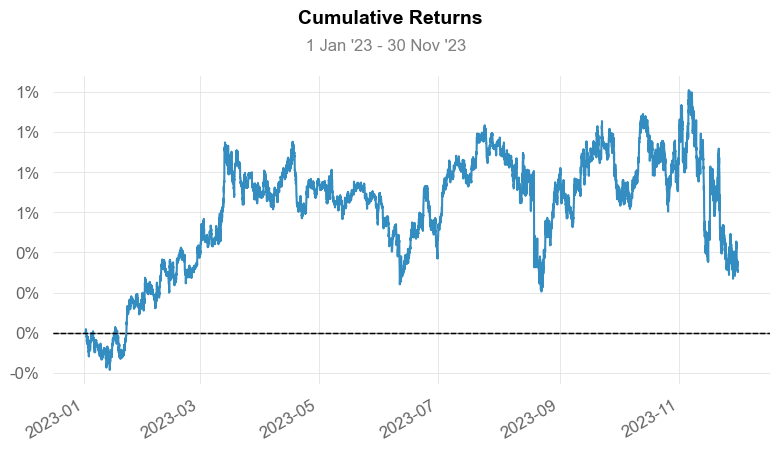

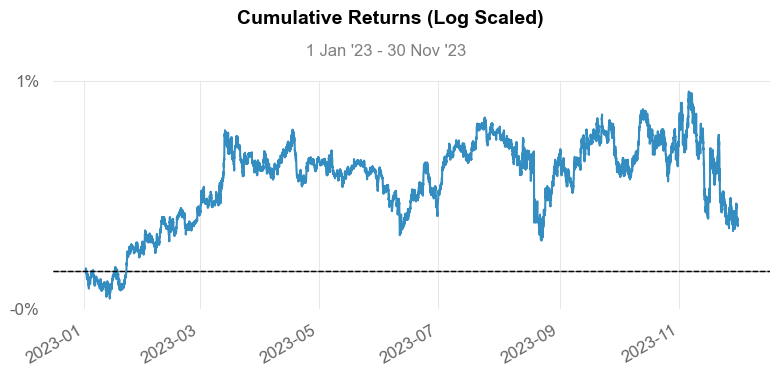

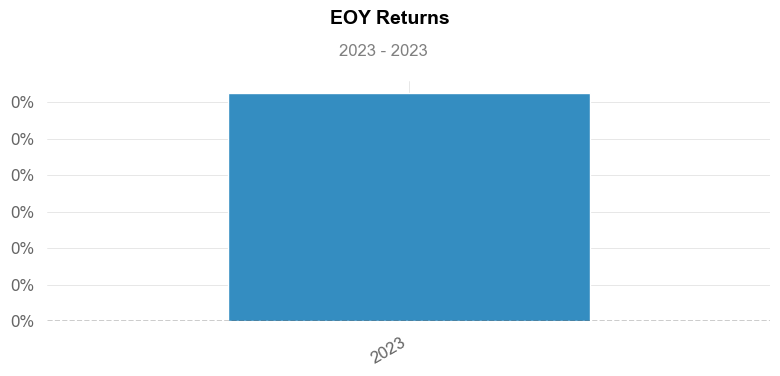

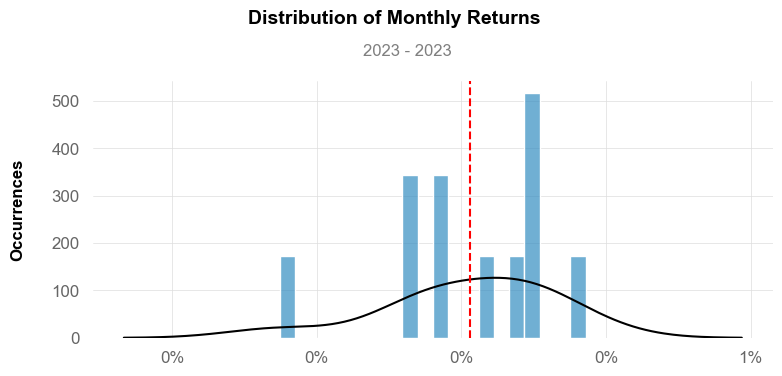

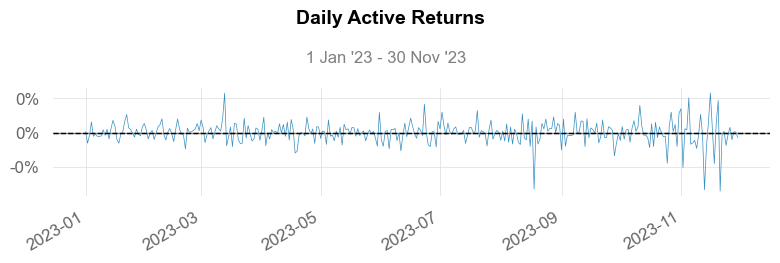

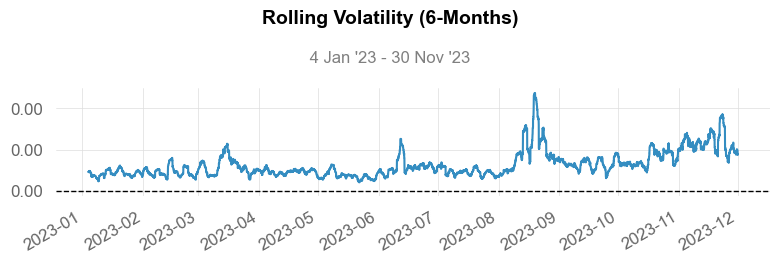

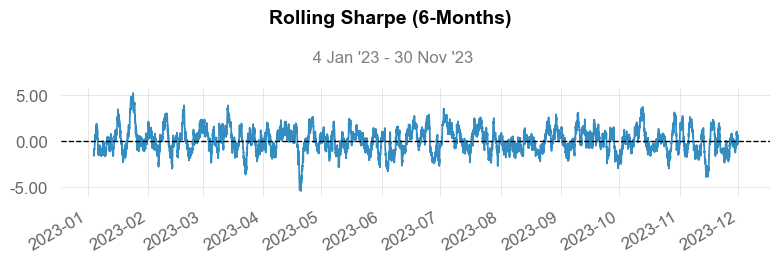

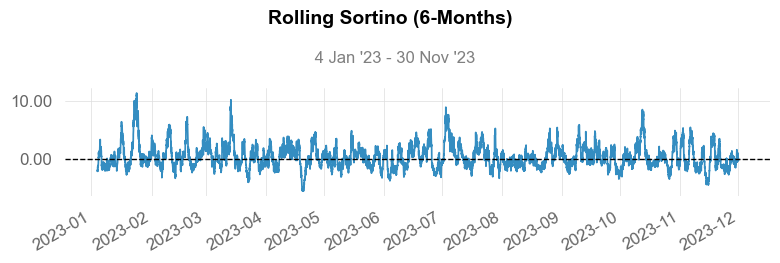

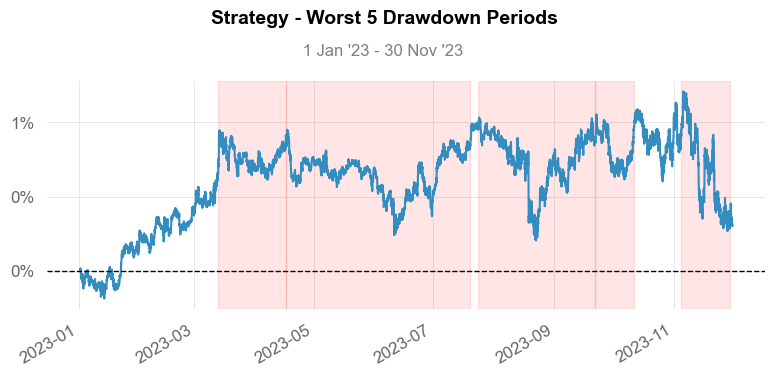

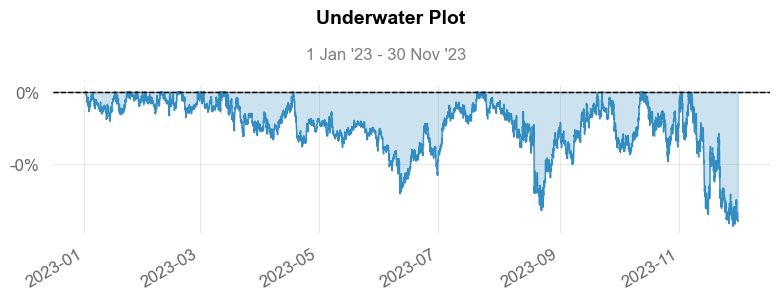

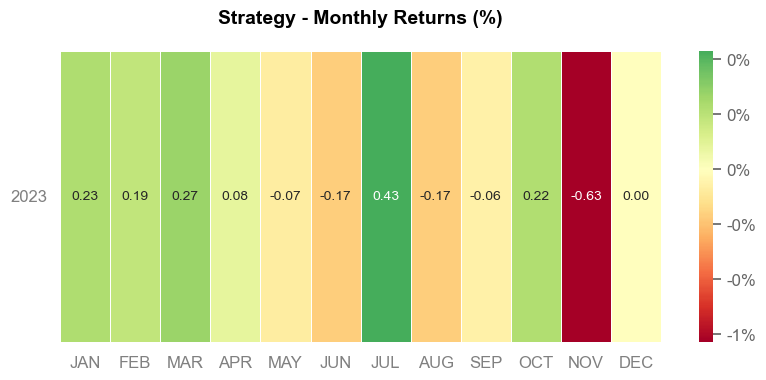

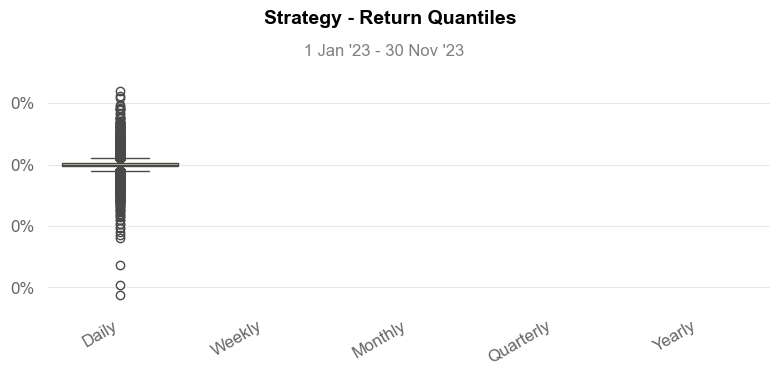

In [16]:
qs.reports.full(best_return['returns'])